<a href="https://colab.research.google.com/github/tobicarvalho/CURL-pytorch-local-replay-buffer-assistance/blob/master/CURL_pytorch_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## imports block
%load_ext autoreload

import matplotlib.pyplot as plt
import torchvision
from torchvision.datasets import MNIST
from torchvision.datasets import Omniglot
import seaborn as sns
import numpy as np
import pickle

import torch
import torch.nn as nn
import copy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


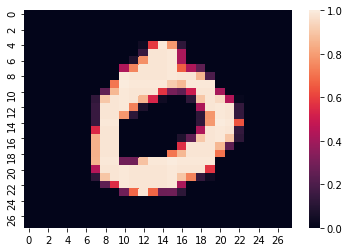

In [ ]:
## dataloader block

def binarize(x):
  return (1.*(x>0.5)).view(1,-1).to(device)

def linear_view(x):
  return x.view(1,-1).to(device)


n_data_per_class = 5000
n_epoch  = 5
n_classe = 5
batch_size = 100

# dataset transformations
MNIST_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), linear_view]) # replace linear_view by binarize to used binarized images like in CURL paper


### Building train_loader ###
dataset = sorted(list(MNIST( root="./data", download=True, train=True, transform=MNIST_transform)), key=lambda tup: tup[1])


# Find index of first digit of each class
light_dataset = []
indice = 0
lim_mnist = [0]
for n, (im, label) in enumerate(dataset):
  if label!=indice:
    indice=label
    lim_mnist.append(n)
lim_mnist.append(-1)

# Sample randomly n_data_per_class for each class and repeat each task for n_epoch
light_dataset = []
for i in range(n_classe):
  temp = dataset[lim_mnist[i]:lim_mnist[i+1]]
  np.random.shuffle(temp)
  light_dataset.extend(n_epoch*temp[:n_data_per_class])


train_loader = torch.utils.data.DataLoader(light_dataset, batch_size=batch_size, shuffle=False) # to train in a IID fashion set shuffle to True


### Building test_loader
dataset = sorted(MNIST( root="./data", download=True, train=False, transform=MNIST_transform), key=lambda tup: tup[1])

# We split per task as weel in order to look at the error for each task overtime
light_dataset = []
indice = 0
lim_mnist = [0]
for n, (im, label) in enumerate(dataset):
  if label!=indice:
    indice=label
    lim_mnist.append(n)
lim_mnist.append(-1)

light_dataset = []
for i in range(n_classe):
  temp = dataset[lim_mnist[i]:lim_mnist[i+1]]
  np.random.shuffle(temp)
  light_dataset.extend(temp[:900])

test_loader = torch.utils.data.DataLoader(light_dataset, batch_size=900)


image, label = dataset[0]
sns.heatmap(image.view(28,28).cpu().numpy())



In [ ]:
## Networks block

class Shared_encoder(torch.nn.Module):
  def __init__(self, D, n_expert):
    ##
    #
    # q(h|x), q(y|x) 
    #    
    # Inputs:
    # - D      : tuple or list of dimension of each layers.
    #
    # Output:
    # - q_h    : shared representation 
    # - q_y    : Probability of every expert 
    ##
    super(Shared_encoder, self).__init__()
    self.net     = nn.ModuleList([nn.Linear(D[i], D[i+1]) for i in range(len(D)-1)])
    self.y_out   = nn.Linear(D[-1],n_expert)

    self.sm      = nn.Softmax(dim=-1)
    self.rl      = nn.ReLU()


  def forward(self, x):
    for layer in self.net:
      x = self.rl(layer(x)) 
    return x, self.sm(self.y_out(x)) # q(h|x), q(y|x)

  

class latent_encoder(torch.nn.Module):
  def __init__(self, s_in = 50, s_out = 32):
    ##
    #
    # q(z|x,y = k)
    #
    # Inputs:
    # - self.s_in   : size on the input.
    # - self.s_out  : size on latent space z.
    #
    # Output:
    # - q(z|x,y = k) : Return the distribution from which z will be drawn.
    #
    # Note:
    # These are the experts, y = k is implicit since this is gonna be the k expert in the list of experts
    ##
    super(latent_encoder, self).__init__()
    self.mu     = nn.Linear(s_in, s_out)
    self.sig    = nn.Linear(s_in, s_out)
    self.sp     = nn.Softplus()
    


  def forward(self, x): 
    mu  = self.mu(x)
    sig = self.sp(self.sig(x))
    return torch.distributions.normal.Normal(mu,sig) #q(z|x,y = k)



class latent_decoder(torch.nn.Module):
  def __init__(self, s_in = 50, s_out = 32):
    ##
    #
    # p(z|y)
    #
    # Inputs:
    # - self.s_in   : size on the input at init time. Should be 1 almost all odf the time.
    # - self.s_out  : size on latent space z.
    #
    # Output:
    # - p(z|y)   : the distribution expected to be assigned for a given y.
    #
    # Note: Only used in the loss function. It is responsible to center each expert around thier given cluster.
    ##
    super(latent_decoder, self).__init__()
    self.mu   = nn.Linear(s_in, s_out)
    self.sig  = nn.Linear(s_in, s_out)
    self.sp      = nn.Softplus()

  def forward(self, x): 
    mu  = self.mu(x)
    sig = self.sp(self.sig(x))
    return torch.distributions.normal.Normal(mu,sig) # p(z|y)


class Shared_decoder(torch.nn.Module):
  def __init__(self, D, s_out):
    ##
    #
    # p(x|z)
    #
    # Inputs:
    # - D      : tuple or list of dimension of each layers.
    # - s_out  : number of pixel of the output dimension.
    #
    # Output:
    # - p(x|z)  : output image. In the CURL paper they used output a bernouilli probability distribution because the images are binarized
    ##
    super(Shared_decoder, self).__init__()
    self.net     = nn.ModuleList([nn.Linear(D[i], D[i+1]) for i in range(len(D)-1)])
    self.x_out   = nn.Linear(D[-1],s_out)

    self.rl = nn.ReLU()
    self.sg = nn.Sigmoid()

  def forward(self, x):
    for layer in self.net:
      x = self.rl(layer(x))  
    return self.sg(self.x_out(x))




class CURL(torch.nn.Module):
  def __init__(self, D_encoder, D_decoder, z_size, n_expert, s_out, max_buffer_size=30):
    ##
    #
    # CURL algorithm
    #
    # Inputs:
    # - D_encoder       : tuple or list of dimension of each layers for the shared encoder. D_encoder[-1] is the size of the h latent space.
    # - D_decoder       : tuple or list of dimension of each layers for the shared decoder.
    # - z_size          : dimension z latent space.
    # - n_expert        : number of expert at starting time. Should be one, except when it is used to create generative CURL used for Generative Replay
    # - s_out           : number of pixel of the output dimension.
    # - max_buffer_size : paramter used for the scaling of the replay buffer (Not initialy in CURL, was part of my project for IFT6760-B course)
    #
    ##
    super(CURL, self).__init__()

    D_encoder = [s_out]+D_encoder
    D_decoder = [z_size]+D_decoder
    self.n_expert = n_expert
    self.s_out = s_out  
    self.max_buffer_size = max_buffer_size

    self.qy = Shared_encoder(D_encoder, n_expert).to(device)
    self.qz = nn.ModuleList([latent_encoder(D_encoder[-1], z_size).to(device) for i in range(n_expert)]) # qz is the list of expert
    self.pz = latent_decoder(n_expert, z_size).to(device)
    self.px = Shared_decoder(D_decoder, s_out).to(device)
    self.register_buffer('prior', torch.zeros(n_expert))
    self.local_buffer = torch.Tensor().to(device)

    # Evaluation metric used over time
    self.evaluation_list = [[], [], [], [], [], [], [], [], [], []] # track evaluation of the performance on each task over time
    self.list_n_expert = [self.n_expert] # track the number of expert over time

  
  def augment(self, idx): 
    # When we augment the CURL alogrithm the new expert is made from a copy of the expert that seem to be the most suited for the task (y=idx).
    # Sometime I was geeting nan error. It always happened right after the creation of a new expert. Not sure if it is because pytorch doesn't like how
    # I copied the already existing parameters. Might worth being investigated. 
    #
    # Also this approach probably don't keep momentum from the adam optimisez because we recreate a new component. Pytorch doesn't seem to allow for 
    # dynamic expension of a linear layer.
    #

    self.qy.y_out  = self.augment_net(net=self.qy.y_out, m=1, idx=idx, dim=1) 
    self.qz.append(copy.deepcopy(self.qz[idx]))

    self.pz.mu   = self.augment_net(net=self.pz.mu, m=1, idx=idx, dim=0)
    self.pz.sig  = self.augment_net(net=self.pz.sig, m=1, idx=idx, dim=0)

    self.prior = torch.nn.functional.pad(self.prior, pad=(0,1), value=0)
    self.n_expert += 1
    return

  def augment_net(self,net, m, idx, dim=1):
    # augment a linear layer in a given dimension and by copying cetain parameter
    s_out, s_in = net.weight.shape 
    if dim == 1:
      new_net = nn.Linear(s_in, s_out + m).to(device)
      
      new_net.weight.data[:s_out,:] = net.weight.data
      new_net.weight.data[s_out:,:] = net.weight.data[idx:idx+1,:]

      new_net.bias.data[:s_out]  = net.bias.data
      new_net.bias.data[s_out:]  = net.bias.data[idx:idx+1]
    else:
      new_net = nn.Linear(s_in+m, s_out).to(device)
      new_net.weight.data[:,:s_in] = net.weight.data
      new_net.weight.data[:,s_in:] = net.weight.data[:,idx:idx+1]
    
    return new_net
  
  def update_prior(self, q, factor=1):
    self.prior = self.prior + factor*q.view(-1).detach()

  def curl_buffer_evaluate(self, batch, similarity, alpha, selection_strat = 'at_expansion'):
    # Evaluation of new samples (batch) for the Replay Buffer
    #
    # We start by verifying if each sample in batch isn't already in the replay buffer in order to avoid duplicate. Then if the combined size of these
    # and the replay buffer is less then the defined threshold, we keep them all. Otherwise, we use the similarity function in order to evaluate which
    # are kept.
    #
    # Inputs:
    # - batch       : Tensor of the batch of samples evaluate for the replay buffer.
    # - similarity  : function used to evaluate the similarity between samples
    # - alpha       : parameter used by the similarity function. Should encapsulated in the function itself to have less useless parameters
    #
    # Output:
    # - local_buffer: local replay buffer updated
    ##
    
    n_RB = self.local_buffer.shape[0] # number of sample in the replay buffer at the beginning
    
    if n_RB==0:
      temp_full  = batch[0:1] 
    else:
      temp_full = self.local_buffer.clone() # detach()? probably not necessary

    ### Add all the candidates that aren't already in the replay buffer  in a list.
    candidates = []
    for candidate in torch.split(batch, 1, dim=0):
      new = (temp_full-candidate.view(1,1,28*28)).sum(dim=2)
      if not any(new==0):
        temp_full = torch.cat([temp_full, candidate], dim=0)
        candidates.append(candidate)


    ### multiple expension strategies have been used
    if selection_strat == 'at_expansion':
      if temp_full.shape[0]<=n_RB+self.max_buffer_size:
        self.local_buffer = temp_full
        return
      else:
        candidates = torch.cat(candidates, dim=0)   
        self.eval()
        h, _ = self.qy(candidates)

        ### Investigation of the similarity in the z-space instead, to be added

        
        selected = similarity(candidates, h, alpha)[:self.max_buffer_size]
        self.local_buffer = torch.cat([self.local_buffer, selected], dim=0)
        self.train()
        return
    
    elif  selection_strat == 'per_bounded':
      if temp_full.shape[0]==n_RB or self.local_buffer.shape[0] <= self.n_expert*self.max_buffer_size:
        self.local_buffer = temp_full
        return

      else:   
        self.eval()
        h, _ = self.qy(temp_full)
        self.local_buffer = similarity(temp_full, h, alpha)[:self.n_expert*self.max_buffer_size]
        self.train()
        return

    elif selection_strat == 'per_unbounded':
      if temp_full.shape[0]<=n_RB+self.max_buffer_size:
        self.local_buffer = temp_full
        return

      else:  
        candidates = torch.cat(candidates, dim=0)   
        self.eval()

        h, _ = self.qy(candidates)
        selected = similarity(candidates, h, alpha)[:self.max_buffer_size]
        self.local_buffer = torch.cat([self.local_buffer, selected], dim=0)
        self.train()
        return
    
    elif selection_strat == 'no_buffer':
      return # haven't test if it's enough
    else:
      raise Exception('Expansion strategy not valid')


  def Sample(self, n_sample, idx=None):
    # Sample n_ample from the CURL algorithm from expert=idx. If idx is None, sample from experts based on prior.
    if idx is not None:
      labels = (torch.ones(n_sample)*idx).to(device).long()
    else:
      labels = torch.distributions.Categorical(self.prior).sample(sample_shape=torch.Size([n_sample])).to(device).detach()

    y = torch.nn.functional.one_hot(labels, self.prior.shape[0]).type(type(self.prior)).to(device)
    z = self.pz(y).sample()

    samples = self.px(z).view(-1,1,self.s_out).detach()
    return samples, labels
  
  def evaluate(self, test_loader):
    # Evaluate reconstruction loss on the test set. 
    self.eval()
    cur_eval = []
    # Evaluate distingly for each task (see how test_loader is made if unclear)
    for i,(batch,_) in enumerate(test_loader):
      h,q_y = self.qy(batch)
      # Find expert associated to each sample
      idx_qy = q_y.argmax(dim=2)
      loss = torch.Tensor([]).to(device)
      
      # For each expert evaluate his reconstruction loss for the samples that are assigned to it
      for idx_qz,qz in enumerate(self.qz):
        if (idx_qy==idx_qz).sum()>0:
          y     = torch.nn.functional.one_hot(torch.tensor(idx_qz), self.prior.shape[0]).type(type(batch)).to(device)

          idx_h = idx_qy==idx_qz
          temp_h = h[idx_h]
          
          temp_batch = batch[idx_h]
          
          p_z_k   = self.pz(y)
          q_z_k = qz(temp_h)
          p_x_k = self.px(q_z_k.rsample())

          loss_px_zy    =  -torch.nn.functional.binary_cross_entropy(p_x_k, temp_batch, reduction='none').sum(dim=1, keepdim=True)

          loss = torch.cat([loss, -loss_px_zy]) 


      self.evaluation_list[i].append(loss.mean().item())
      cur_eval.append(round(loss.mean().item(),2))
    print('cur_eval: ', cur_eval)
    self.list_n_expert.append(self.n_expert)
    self.train()

  def analyse_experts(self, n_image = 15, n_model=0, n_execution=0):
    # Exploration of the latent space of each experts (in one direction and going over their cluster center)
    image_tot = np.zeros((self.n_expert*28, n_image*28))

    for idx in range(self.n_expert):
      labels = (torch.ones(1)*idx).to(device).long()
      y = torch.nn.functional.one_hot(labels, self.prior.shape[0]).type(type(self.prior)).to(device)

      mean = self.pz(y).loc
      scale = self.pz(y).scale
      
      for i in range(n_image):
        sample = self.px(mean+(2*i-n_image)*0.1*scale).view(-1,1,self.s_out).detach()
        image_tot[idx*28:(idx+1)*28, i*28:(i+1)*28] = sample.view(-1,28,28).cpu().numpy()

    fig = plt.figure(figsize=[15, 15])
    plt.imshow(image_tot)
    plt.yticks(np.arange(14,14+curl.n_expert*28,28), [str(x) for x in range(curl.n_expert)])
    plt.xticks(np.arange(14,14+n_image*28,28), [str(2*x-n_image+1) for x in range(n_image)])
    plt.ylabel('expert no.')
    plt.xlabel(r'$\mu+x*\sigma$')
    plt.savefig('latent_exploration_per_expert_'+str(n_execution)+'_model_'+str(n_model))






In [ ]:
## Function block

def supervised_lost(curl, idx, batch):
  ##
  #
  # supervised lost function.
  #
  # Inputs:
  # - curl      : CURL algorithm for whom the lost is evaluated.
  # - idx       : Vector containing the index of the expert related to each data.
  # - batch     : batch of data over which the loss is calculated (Could be from more then one experts). 
  #
  # Outputs:
  # - loss      : resulting loss function
  # - q_y       : q(y|x) for each data. Not currently used and could be remove
  ##
  h,q_y = curl.qy(batch)

  loss = torch.Tensor([]).to(device)

  # For each expert evaluate his reconstruction loss for the samples that are assigned to it
  for idx_qz,qz in enumerate(curl.qz):
    if (idx==idx_qz).sum()>0:
      y     = torch.nn.functional.one_hot(torch.tensor(idx_qz), curl.prior.shape[0]).type(type(batch)).to(device)

      idx_h = idx==idx_qz
      temp_h = h[idx_h]
      
      temp_batch = batch[idx_h]

      p_z_k   = curl.pz(y)
      q_z_k = qz(temp_h)
      p_x_k = curl.px(q_z_k.rsample())

      loss_px_zy    =  -torch.nn.functional.binary_cross_entropy(p_x_k, temp_batch, reduction='none').sum(dim=2, keepdim=True)
      loss_KL_qz_pz =  torch.distributions.kl.kl_divergence(q_z_k, p_z_k).sum(dim=2, keepdim=True)
      log_qy        =  q_y[idx_h,:,idx_qz:idx_qz+1].log()

      # See CURL paper for details about each parameters
      loss = torch.cat([loss, -(loss_px_zy - loss_KL_qz_pz + log_qy)]) 
      

  return loss , q_y

def unsupervised_lost(curl, batch):
  ##
  #
  # unsupervised lost function.
  #
  # Inputs:
  # - curl      : CURL algorithm for whom the lost is evaluated.
  # - batch     : batch of data over which the loss is calculated. 
  #
  # Outputs:
  # - loss      : resulting loss function
  # - q_y       : q(y|x) for each data. Not currently used and could be remove
  ##

  h,q_y = curl.qy(batch)
  # test = torch.distributions.categorical.Categorical(probs=q_y)
  # entropy = test.logits * test.probs  

  py = torch.ones(batch.shape[0],1,curl.n_expert).to(device)/curl.n_expert
  loss = -torch.nn.functional.kl_div(q_y, py,  reduction = 'none').sum(dim=2, keepdim=True) # -KL(q(y|x)||p(y)), Categorical regulariser


  for idx,qz in enumerate(curl.qz): # sum q(y=k|x)*[p(x|x)-KL(q(z|x,y=k)||p(z|y=k))]
    y     = torch.nn.functional.one_hot(torch.tensor(idx), curl.prior.shape[0]).type(type(batch)).to(device)

    p_z_k   = curl.pz(y)  
    q_z_k = qz(h)
    p_x_k = curl.px(q_z_k.rsample())

    loss_px_zy    =  -torch.nn.functional.binary_cross_entropy(p_x_k, batch, reduction='none').sum(dim=2, keepdim=True)


    loss_KL_qz_pz =  torch.distributions.kl.kl_divergence(q_z_k, p_z_k).sum(dim=2, keepdim=True)


    q_y_loss = (q_y[:,:,idx:idx+1]*(loss_px_zy-loss_KL_qz_pz))



    loss          += q_y_loss

  

  return - loss, q_y

def train_expend(curl, optimizer, poor_buffer, epoch=20, expend=True):
  ##
  #
  # Training sequence when a new expert is created
  #
  # Inputs:
  # - curl        : CURL algorithm for whom the lost is evaluated.
  # - optimizer   : optimizer used to train the CURL algorithm. 
  # - poor_buffer : buffer containing the samples that have a loss bigger then the defined threshold
  # - epoch       : number of training epochs.
  # - expend      : Weither a expert should be created or not. Currently is only False for the training of the first batch of samples since one expert
  #                 is created at CURL initialisation. Might be usefull in the future if a maximum number of expert is fixed and we still want to 
  #                 accumuated poor samples.
  #
  # Outputs:
  # - optimizer   : As mentionned earlier, Pytorch doesn't seem to have a goood way to expend already existing layers. Because of this we recreates layers
  #                 and copy their previous content at the right place. However, because of this the optimizer must be updated. We choose to reinitialise
  #                 it completly since the previous parameter reference isn't used anymore. Just adding those parameter to the current optimizer parameter
  #                 dictionnary would keep reference to them, preventing them to be deleted in order to free space. A more elequent strategy might be found.
  #                 
  ##
  
  if expend:
    _,q_y = unsupervised_lost(curl, batch)
    idx = q_y.sum(dim=0).argmax() # We want to create the new expert from the best existing expert

    curl.augment(idx)
    optimizer = torch.optim.Adam(curl.parameters(), lr=lr) # As mentionned, we recreate the optimizer
  curl.train()
  
  for i in range(epoch): 

    loss , q_y= supervised_lost(curl, torch.tensor(curl.n_expert-1).repeat(batch.shape[0]), batch)
    loss      = loss.mean()



    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  y = torch.nn.functional.one_hot(torch.tensor(curl.prior.shape[0]-1), curl.prior.shape[0]).type(type(batch)).to(device)
  curl.update_prior(y, factor=batch.shape[0]) # update the prior

  return optimizer


def gen_batch_maker(batch_loader, curl, gen_curl, gen_idx, batch_number, curr_batch, curr_label, lam=0.1):
  ##
  #
  # batch generator that mix data from the 3 sources (true data, generative replay and replay buffer)
  #
  # Inputs:
  # - batch_loader  : generator that yield next batch of true data
  # - curl          : current CURL instance
  # - gen_curl      : instance of CURL used for Generative Replay
  # - gen_idx       : reference index used to determined when we take a new batch from the true data
  # - batch_number  : current batch number in the dataloader.
  # - curr_batch    : current batch of true data. Only updated if gen_idx=0.
  # - curr_label    : current label of true data. Only updated if gen_idx=0. Not used, but might be usefull in the futur.
  # - lam           : coefficient adjusting ratio between generative replay and replay buffer usage.
  #
  # Outputs:
  # - batch_number  : see input, it's passed around.
  # - batch         : next batch of data used for training (mix of the 3 sources)
  # - label         : class label for true data, expert label for GR data, zeros for data from replay buffer
  # - is_sup        : boolean vector saying is associated data must be train in supervised or unsupervised fashion
  # - true_data     : boolean vector saying if associated data is from the true data or not (mainly to restrict replay buffer to true data). 
  # - is_finish     : boolean value saying is training is finished or not (aka there is no more data in the dataloader)
  # - gen_idx       : see input, it's passed around.
  # - curr_batch    : see input, it's passed around.
  # - curr_label    : see input, it's passed around.
  ##


  if not gen_curl:
    batch_number, curr_batch, curr_label, is_finish = next(batch_loader)
    curr_is_sup = torch.zeros(curr_batch.shape[0]).long()
    curr_true_data = torch.ones(curr_batch.shape[0]).long()
    return batch_number, curr_batch, curr_label, curr_is_sup, curr_true_data, is_finish, gen_idx, curr_batch, curr_label

  elif gen_idx==0:
    # true data update, is no more data left return is_finish = True
    batch_number, curr_batch, curr_label, is_finish = next(batch_loader)
    if is_finish:
      return [], [], [], [], [], is_finish, [], [], []
  else:
    is_finish = False
  
  n_sample = curr_batch.shape[0]
  is_buffer = curl.local_buffer.shape[0] > 0

  gen_idx += 1 
  curr_is_sup = torch.zeros(n_sample).long()
  curr_true_data = torch.ones(n_sample).long()

  # number of samples using generative replay
  n_s = int(max((1-lam*is_buffer)*gen_curl.n_expert*n_sample, n_sample))

  sampled_batch, sampled_label = gen_curl.Sample(n_s)
  sampled_is_sup = torch.zeros(n_s).long() # if using supervised training comment this line and uncomment the following one
  # sampled_is_sup = torch.ones(n_s).long()
  sampled_true_data = torch.zeros(n_s).long()


  if is_buffer:
    idx = torch.randperm(curl.local_buffer.shape[0])

    # number of samples from replay buffer
    n_local = int(min(lam*gen_curl.n_expert*n_sample, curl.local_buffer.shape[0]))

    local_batch = curl.local_buffer[idx[:n_local]] 

    local_label = torch.zeros(local_batch.shape[0]).to(device).long()

    local_is_sup = torch.zeros(local_batch.shape[0]).long()
    local_true_data = torch.zeros(local_batch.shape[0]).long()


    sources = [(curr_batch, curr_label, curr_is_sup, curr_true_data),\
               (sampled_batch, sampled_label, sampled_is_sup, sampled_true_data),\
               (local_batch, local_label, local_is_sup, local_true_data)\
               ]
    batch, label, is_sup, true_data = multiple_source_sampler(sources, n_sample) # Sampling from the mix of sources
  else:
    sources = [(curr_batch, curr_label, curr_is_sup, curr_true_data),\
               (sampled_batch, sampled_label, sampled_is_sup, sampled_true_data)\
               ]
    batch, label, is_sup, true_data = multiple_source_sampler(sources, n_sample) # Sampling from the mix of sources
  
  if gen_idx>=curl.n_expert: # next batch condition
    gen_idx = 0

  return batch_number, batch, label, is_sup, true_data, is_finish, gen_idx, curr_batch, curr_label
  




def multiple_source_sampler(sources, n_sample):
  ##
  #
  # Sampler from multiple sources
  #
  # Inputs:
  # - sources   : The sources of data and their attribute that are gonna be sampled from.
  # - n_sample  : Number of samples selected from the sources. 
  #
  # Outputs:
  # - Sub sample of sources
  ##
  fused_batch = sources[0][0]
  fused_label = sources[0][1]
  fused_is_sup= sources[0][2]
  fused_true  = sources[0][3]

  for batch, label, is_sup, true_data in sources[1:]:

    fused_batch = torch.cat((fused_batch, batch), dim=0)
    fused_label = torch.cat((fused_label, label), dim=0)
    fused_is_sup  = torch.cat((fused_is_sup, is_sup), dim=0)
    fused_true  = torch.cat((fused_true, true_data), dim=0)
  
  idx = list(range(fused_batch.shape[0]))
  np.random.shuffle(idx)
  
  sampled_batch = torch.cat([fused_batch[i:i+1] for i in idx[:n_sample]], dim = 0)
  sampled_label = torch.cat([fused_label[i:i+1] for i in idx[:n_sample]], dim = 0)
  sampled_is_sup  = torch.cat([fused_is_sup[i:i+1] for i in idx[:n_sample]], dim = 0)
  sampled_true  = torch.cat([fused_true[i:i+1] for i in idx[:n_sample]], dim = 0)
  
  return sampled_batch, sampled_label, sampled_is_sup, sampled_true


def batch_sampler(data_loader):
  ##
  #
  # Generator that yield true data from data_loader
  #
  # Inputs:
  # - data_loader  : dataloader from which the true data are taken 
  #
  # Outputs:
  # - current batch and end condition
  ##
  for batch_number, (batch, label) in enumerate(data_loader):
    yield batch_number+1, batch.to(device), label.to(device), False
  yield [],[],[],True

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Execution:  0  batch number:  253 on:  1250 ( 20.0 %)
mean loss 171.8566436767578  n_expert:  4  number of poor sample: tensor(0) / tensor(22)
cur_eval:  [169.49, 89.22, 254.18, 233.38, 233.45]


Execution:  0  batch number:  254 on:  1250 ( 20.0 %)
mean loss 175.4801483154297  n_expert:  4  number of poor sample: tensor(0) / tensor(21)
cur_eval:  [168.68, 86.63, 253.28, 233.43, 234.35]


Execution:  0  batch number:  255 on:  1250 ( 20.0 %)
mean loss 166.5038299560547  n_expert:  4  number of poor sample: tensor(0) / tensor(27)
cur_eval:  [167.89, 83.42, 253.32, 233.63, 234.97]


Execution:  0  batch number:  256 on:  1250 ( 20.0 %)
mean loss 172.9413299560547  n_expert:  4  number of poor sample: tensor(0) / tensor(19)
cur_eval:  [166.01, 80.19, 253.48, 234.49, 233.15]


Execution:  0  batch number:  257 on:  1250 ( 21.0 %)
mean loss 166.2245330810547  n_expert:  4  number of poor sample: tensor(0) / tensor

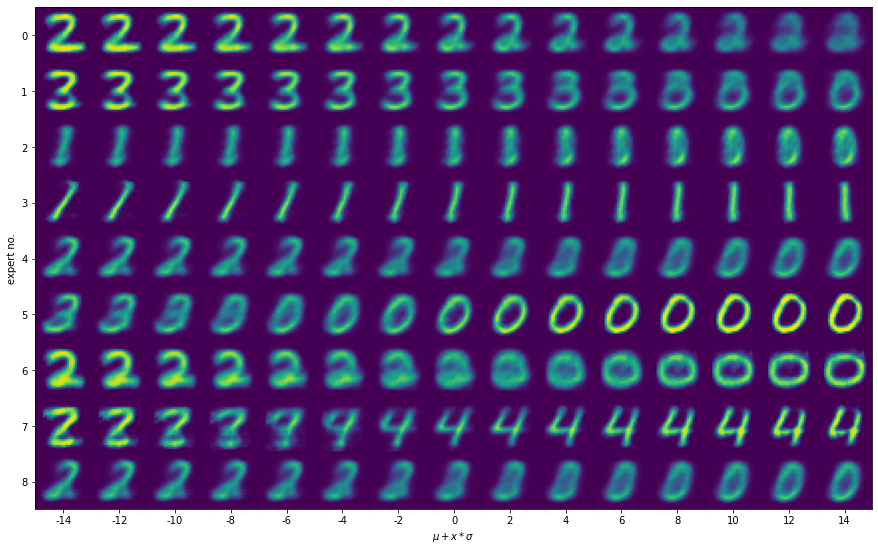

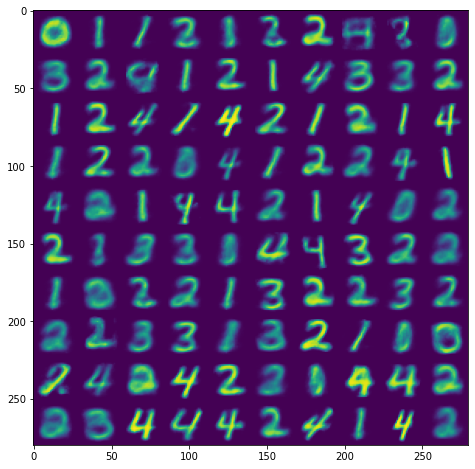

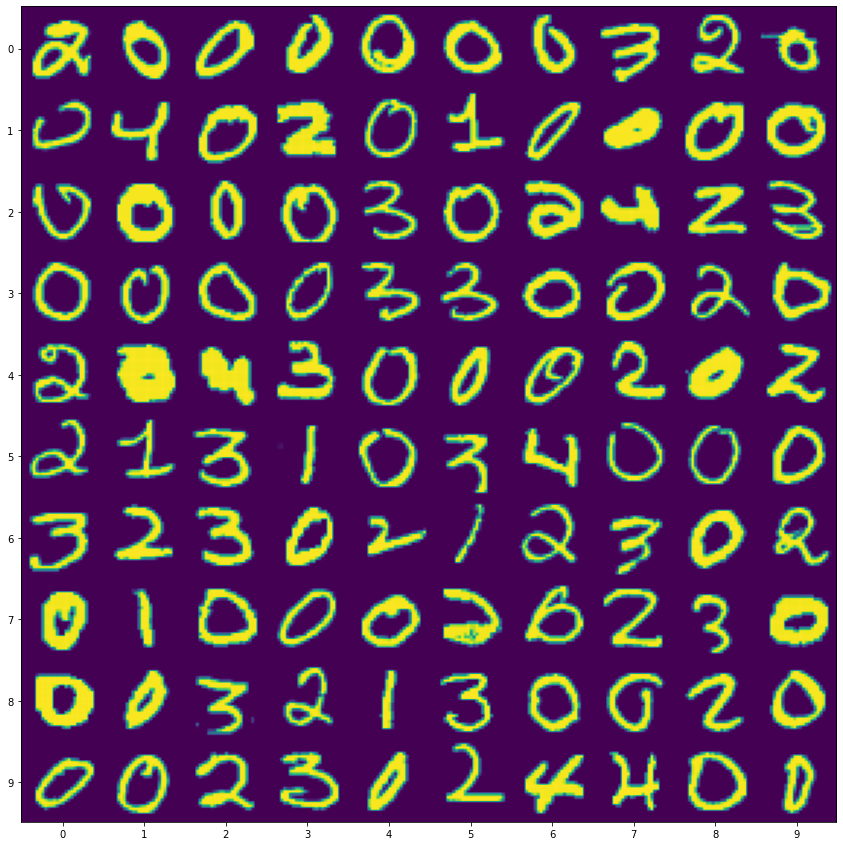

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.


Execution:  1  batch number:  253 on:  1250 ( 20.0 %)
mean loss 167.84214782714844  n_expert:  3  number of poor sample: tensor(0) / tensor(40)
cur_eval:  [155.33, 110.35, 235.9, 215.19, 216.84]


Execution:  1  batch number:  254 on:  1250 ( 20.0 %)
mean loss 168.32809448242188  n_expert:  3  number of poor sample: tensor(0) / tensor(30)
cur_eval:  [157.79, 96.47, 240.87, 219.04, 224.96]


Execution:  1  batch number:  255 on:  1250 ( 20.0 %)
mean loss 158.98214721679688  n_expert:  3  number of poor sample: tensor(0) / tensor(36)
cur_eval:  [161.21, 86.64, 239.26, 219.78, 227.35]


Execution:  1  batch number:  256 on:  1250 ( 20.0 %)
mean loss 159.58938598632812  n_expert:  3  number of poor sample: tensor(1) / tensor(31)
cur_eval:  [157.27, 81.96, 240.88, 220.5, 225.54]


Execution:  1  batch number:  257 on:  1250 ( 21.0 %)
mean loss 149.4331512451172  n_expert:  3  number of poor sample: tensor(0) / t

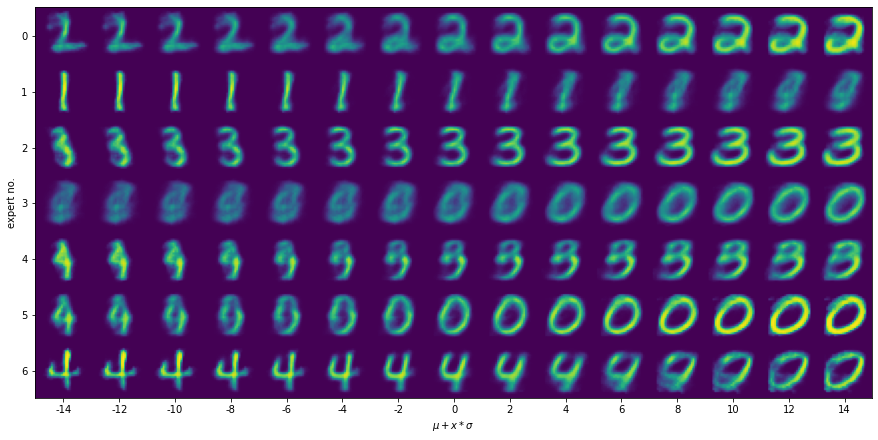

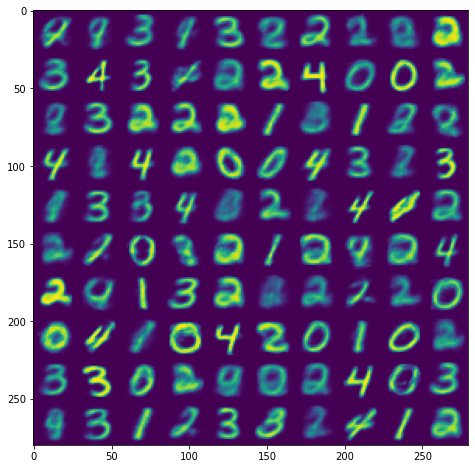

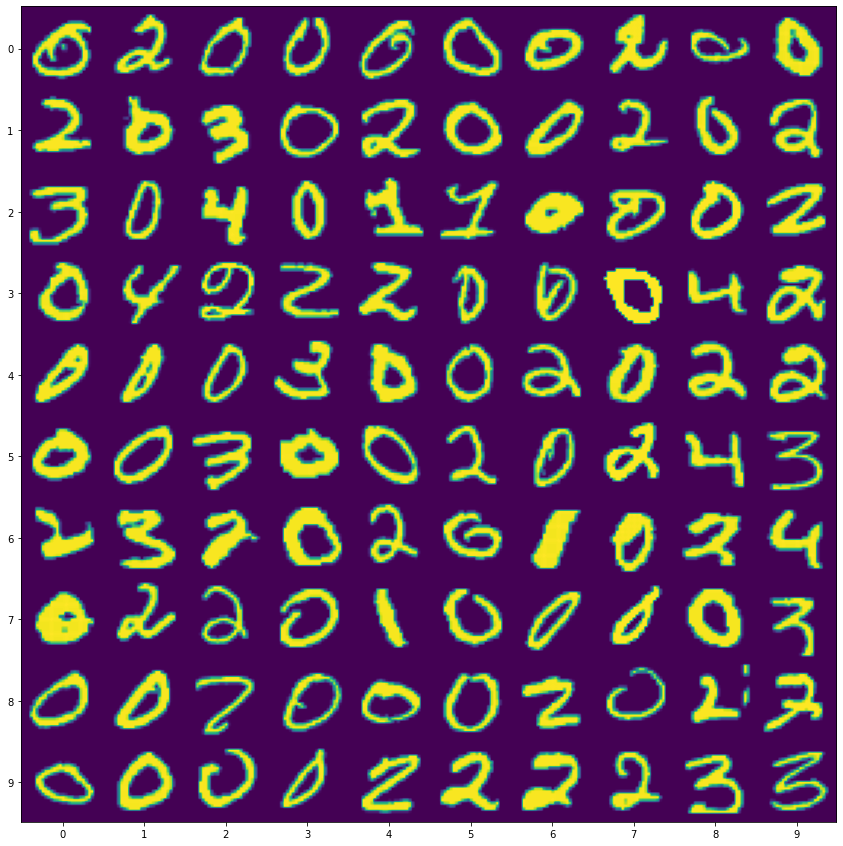

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Execution:  2  batch number:  253 on:  1250 ( 20.0 %)
mean loss 169.7939453125  n_expert:  3  number of poor sample: tensor(0) / tensor(28)
cur_eval:  [153.54, 110.7, 244.5, 221.88, 221.92]


Execution:  2  batch number:  254 on:  1250 ( 20.0 %)
mean loss 161.25418090820312  n_expert:  3  number of poor sample: tensor(0) / tensor(30)
cur_eval:  [158.41, 96.56, 253.82, 226.19, 234.36]


Execution:  2  batch number:  255 on:  1250 ( 20.0 %)
mean loss 153.34158325195312  n_expert:  3  number of poor sample: tensor(1) / tensor(39)
cur_eval:  [156.9, 93.05, 256.06, 228.77, 237.37]


Execution:  2  batch number:  256 on:  1250 ( 20.0 %)
mean loss 156.2698974609375  n_expert:  3  number of poor sample: tensor(1) / tensor(37)
cur_eval:  [157.98, 91.05, 255.66, 228.63, 238.71]


Execution:  2  batch number:  257 on:  1250 ( 21.0 %)
mean loss 153.76254272460938  n_expert:  3  number of poor sample: tensor(0) / tensor(2

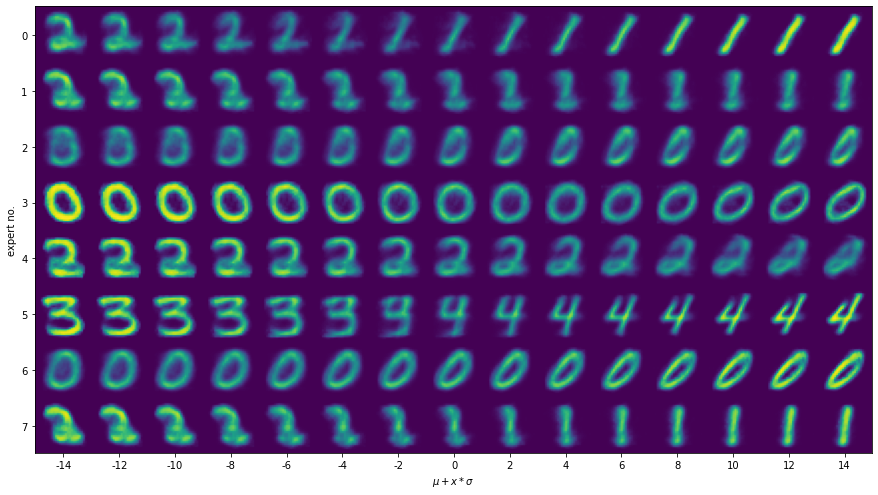

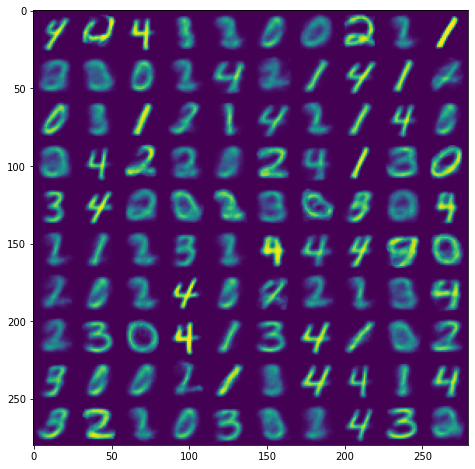

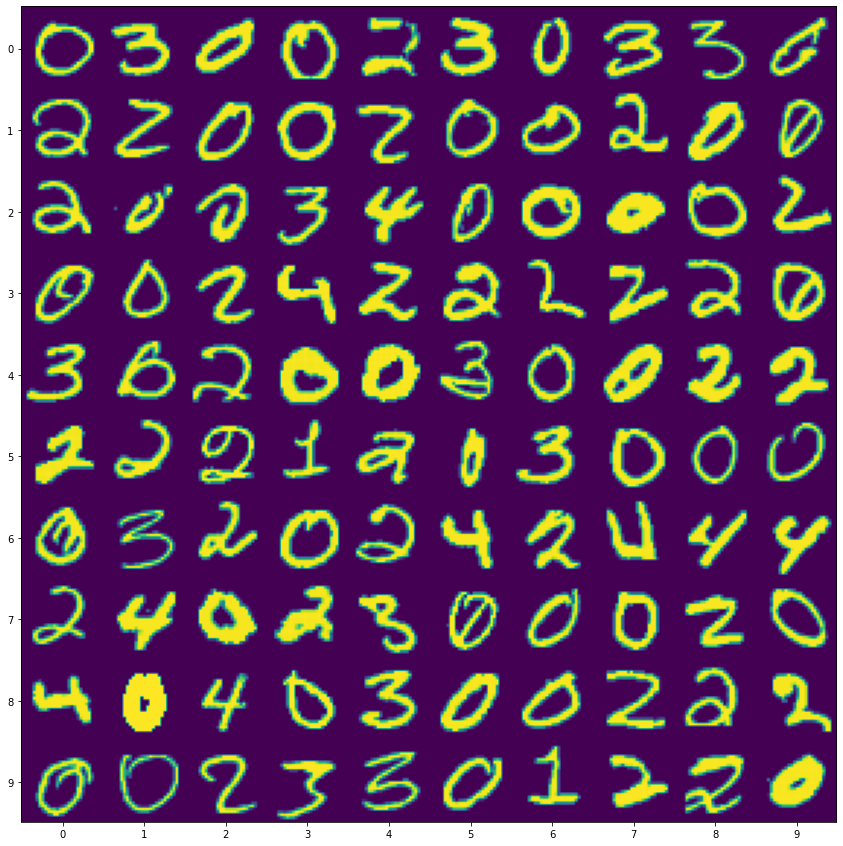

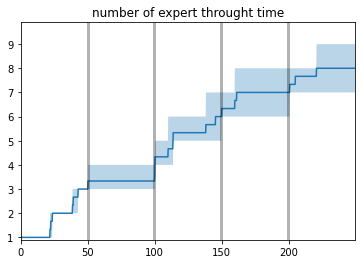

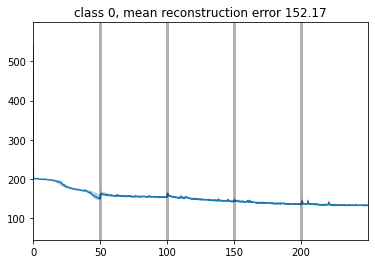

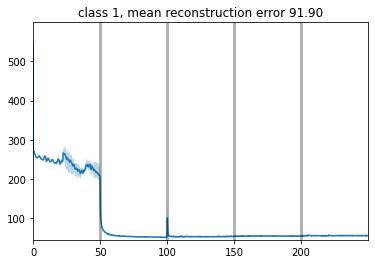

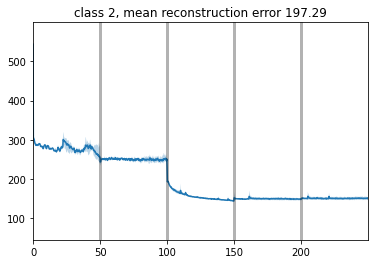

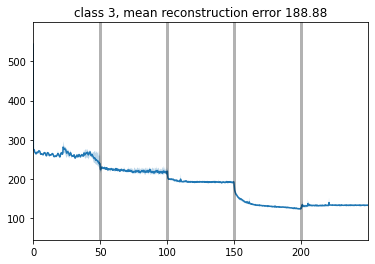

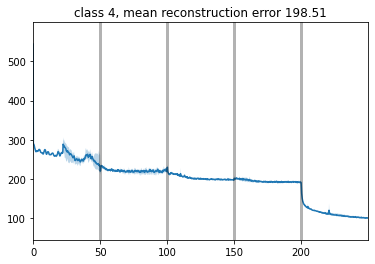

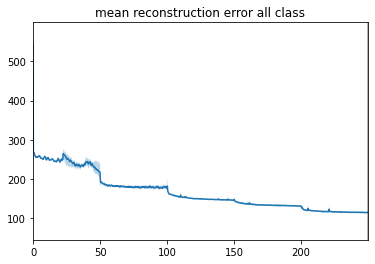

In [ ]:
## Main block


# %xmode Verbose
# %xmode Context

def similarity(batch, lat, alpha):
  # similarity measure
  lat = lat.detach()
  mean_real = batch.mean(dim=0, keepdim=True)
  mean_lat  = lat.mean(dim=0, keepdim=True)


  diff_real  = (batch-mean_real)**2
  diff_lat   = (lat-mean_lat)**2

  criteria = alpha*diff_real.mean(dim=2)/diff_real.mean() + (1-alpha)*diff_lat.mean(dim=2)/diff_lat.mean()
  idx      = criteria.view(-1).argsort(descending=True)

  return batch[idx]

# Uncomment function bellow to use random sampling instead of similarity sampling method
# def similarity(batch, lat, alpha):
  
#   idx = list(range(batch.shape[0]))
#   np.random.shuffle(idx)

#   return batch[idx]



#################################################### Experiment ####################################################



n_execution = 3 # number of execution
model = 0       # model number
alpha = 0       # Similarity importance ratio
CL_setup = True # If false iid data will be used
selection_strat = 'at_expansion' # Options: 'at_expansion', 'per_bounded', 'per_unbounded', None

lr = 1e-3
D_Encoder = [1200, 600, 300, 150]
D_Decoder = [500, 500]
h_size    = 32

exp_wait_steps = 100  # Steps to wait after expansion before eligible again
max_buffer_size = 100  # Size of the buffer of poorly explained data
num_buffer_train_steps = 30  # Num steps to train component on buffer
RB_buffer_size  = 100 # Total buffer size will depend of selection_strat, should be considerably smaller for 'per_unbounded' 
threshold = 240




list_exect  = []
list_n_expert_tot=[]
list_prior = []
for idx_exect in range(n_execution):

  curl = CURL(D_Encoder, D_Decoder, h_size, 1, 28*28, RB_buffer_size).to(device)



  optimizer = torch.optim.Adam(curl.parameters(), lr=lr)

  poor_buffer = None
  batch_number = 0
  prev_batch_number = -1
  last_update = 0
  total_ts    = 0
  last_train  = 0
  is_finish = False
  true_data = True
  gen_idx   = 0
  gen_curl  = None

  
  if CL_setup:
    batch_loader = batch_sampler(train_loader)
  else:
    batch_loader = batch_sampler(unsorted_train_loader)



  curr_batch, curr_label = (None, None)
  curl.evaluate(test_loader)


  while True:

    batch_number, batch, label, is_sup, true_data, is_finish, gen_idx, curr_batch, curr_label = gen_batch_maker(batch_loader, curl, gen_curl, gen_idx, batch_number, curr_batch, curr_label)
    

    if is_finish:
      print('finished')
      break
    
    
    if batch_number != prev_batch_number: 
      prev_batch_number = batch_number
      show = True
    else:
      show = False 
      
    if show:
      print('\n\nExecution: ', idx_exect, ' batch number: ', batch_number, 'on: ', len(train_loader), '(', 100*round(batch_number/len(train_loader),2), '%)')
      
      

    if batch_number==1:
      optimizer = train_expend(curl, optimizer, batch, num_buffer_train_steps, expend=False)
      if selection_strat:
          curl.curl_buffer_evaluate(batch, similarity, alpha, selection_strat)
          print('\nnexpert: ', curl.n_expert, ' local_buffer_size: ', curl.local_buffer.shape[0])
      continue

    # spliting the supervised and unsupervised samples
    loss_sup    = torch.Tensor().to(device)
    batch_sup   = batch[is_sup]
    label_sup   = label[is_sup]

    batch_unsup = batch[is_sup==0]
    true_data_unsup = true_data[is_sup==0]

    if any(is_sup): 
      loss_sup, q_y = supervised_lost(curl, label_sup, batch_sup)
      # curl.update_prior(q_y.sum(dim=0), factor=1) # prior should not be update on other data then the true data?


    loss_unsup, q_y = unsupervised_lost(curl, batch_unsup)
    
    idx_poor = (np.logical_and(loss_unsup.view(-1).cpu() > threshold,  last_update > exp_wait_steps) * true_data_unsup).bool()
    
    if show:
      print('mean loss', torch.cat([loss_sup, loss_unsup], dim=0).mean().item(),' n_expert: ', curl.n_expert, ' number of poor sample:', idx_poor.sum(),'/', true_data_unsup.sum())
    
    # if some data aren't poor
    if not all(idx_poor):
      idx_update = np.logical_and(idx_poor==0, true_data_unsup).bool()
      q_y_update = q_y[idx_update]
      curl.update_prior(q_y_update.sum(dim=0), factor=1) # only update prior base on true_data
      
      loss     = torch.cat([loss_sup, loss_unsup[idx_poor==0]], dim=0).mean()
      

      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    if (selection_strat == 'per_bounded' or selection_strat == 'per_unbounded') and gen_idx==0 and batch_number % 250 > 200:
      if show:
        print('buffer_evaluate, number of possible sample:', curl.n_expert*curl.max_buffer_size, ' and ', curl.local_buffer.shape[0], ' sample in local buffer')
      curl.curl_buffer_evaluate(curr_batch, similarity, alpha, selection_strat) #true_data




    if any(idx_poor):
      # add poor sample to poor buffer
      if poor_buffer is None:
        poor_buffer = batch_unsup[idx_poor]
      else:
        poor_buffer = torch.cat([poor_buffer, batch_unsup[idx_poor]], dim=0)
      
      # if number of sample in poor buffer exceed limit create a new expert
      if poor_buffer.shape[0] > max_buffer_size:
        
        gen_curl = CURL(D_Encoder, D_Decoder, h_size, curl.n_expert, 28*28, RB_buffer_size).to(device)
        gen_curl.load_state_dict(curl.state_dict())
        
        optimizer = train_expend(curl, optimizer, poor_buffer, num_buffer_train_steps, expend=True)

        if selection_strat == 'at_expansion':
          h, _ = curl.qy(poor_buffer)
          curl.curl_buffer_evaluate(poor_buffer, similarity, alpha, selection_strat) 
          print('\nnexpert: ', curl.n_expert, ' local_buffer_size: ', curl.local_buffer.shape[0])
        else:
          print('\nnexpert: ', curl.n_expert)

        poor_buffer = None
        last_update = 0
        

    last_update += 1

    if show:
        curl.evaluate(test_loader)
    
  list_exect.append(curl.evaluation_list)
  list_n_expert_tot.append(curl.list_n_expert)
  torch.save(curl.state_dict(), 'CURL_model_'+str(model)+'_exect_'+ str(idx_exect))

########################################### Plotting exploration of the latent space #################################################################    
  
  curl.analyse_experts(n_image = 15, n_model=model, n_execution=idx_exect)


########################################### Sample generated by CURL ###########################################
  w=10
  h=10
  img, label = curl.Sample(h*w)
  image_tot = np.zeros((h*28, w*28))
  for i in range(w):
    for j in range(h):
      image_tot[j*28:(j+1)*28, i*28:(i+1)*28] = img[j*h+i].view(-1,28,28).detach().cpu().numpy()
  fig = plt.figure(figsize=[8, 8])
  plt.imshow(image_tot)
  plt.savefig('samples_gen_ex'+str(idx_exect)+'_model_'+str(model))

########################################## Replay buffer visualisation ############################################################
  n_image = int(min(10, curl.local_buffer.shape[0]**0.5))

  image_tot = np.zeros((n_image*28, n_image*28))

  idx = torch.randperm(curl.local_buffer.shape[0])

  img = curl.local_buffer[idx]


  for i in range(n_image):
    for j in range(n_image):
      image_tot[i*28:(i+1)*28, j*28:(j+1)*28] = img[i*n_image+j].view(-1,28,28).detach().cpu().numpy()

  fig = plt.figure(figsize=[15, 15])
  plt.imshow(image_tot)
  plt.yticks(np.arange(14,14+n_image*28,28), [str(x) for x in range(n_image)])
  plt.xticks(np.arange(14,14+n_image*28,28), [str(x) for x in range(n_image)])

  plt.savefig('RB_model_ex'+str(idx_exect)+'_model_'+str(model))
  plt.show()
  list_prior.append(curl.prior.cpu().numpy())

########################################### Number of experts over time ##################################################################


savefig = True

mean_expert = np.mean(np.array(list_n_expert_tot), axis=0)
min_expert  = np.min(np.array(list_n_expert_tot), axis=0)
max_expert  = np.max(np.array(list_n_expert_tot), axis=0)

l    = mean_expert.shape[0]
x    = n_epoch*n_data_per_class/batch_size/l*np.arange(l)

up   = 1.1*np.max(max_expert)
down = 0.9*np.min(max_expert)

plt.plot(x,mean_expert)
plt.fill_between(x, min_expert, max_expert, alpha=0.3)

for i in range(1,n_classe):
  x_loc = i*x[-1]/n_classe
  plt.plot([x_loc, x_loc],[down,up], 'k', linewidth=3,  alpha=0.3)
plt.ylim([down,up])
plt.xlim([0, x[-1]])
plt.title('number of expert throught time')

if savefig:
  plt.savefig('n_expert_model_'+str(model))
plt.show()

############################################## Performance on test set over time #######################################################

full_list = []
for eval_ex in list_exect:
  corr_list =[]
  for ex in eval_ex[:5]:
    corr_list.append(ex)
  full_list.append(corr_list)


mean_ex =np.mean(np.array(full_list), axis=0)
min_ex =np.min(np.array(full_list), axis=0)
max_ex =np.max(np.array(full_list), axis=0)


l = np.max(mean_ex.shape)
x = n_epoch*n_data_per_class/batch_size/l*np.arange(l)

down = 0.9*np.min(min_ex)
up   = 1.1*np.max(max_ex)
for i in range(n_classe):
  fig = plt.figure()
  plt.plot(x, mean_ex[i])
  plt.fill_between(x, min_ex[i], max_ex[i], alpha=0.3)
  for j in range(1,n_classe):
    x_loc = j*x[-1]/n_classe
    plt.plot([x_loc, x_loc],[down,up], 'k', linewidth=3,  alpha=0.3)
  plt.title('class {}, mean reconstruction error {:0.2f}'.format(i, np.mean(mean_ex[i])))
  plt.xlim([0, x[-1]])
  plt.ylim([down,up])
  if savefig:
    plt.savefig('error_class_' + str(i)+'_model_'+str(model))
  plt.show()

############################################ Mean performance on test set over time ##############################################

plt.plot(x,np.mean(mean_ex, axis=0))
plt.fill_between(x, np.mean(min_ex, axis=0), np.mean(max_ex, axis=0), alpha=0.3)
for j in range(1,n_classe):
  x_loc = j*l/n_classe
  plt.plot([x_loc, x_loc],[down,up], 'k', linewidth=3,  alpha=0.3)
plt.title('mean reconstruction error all class')
plt.xlim([0, x[-1]])
plt.ylim([down,up])

if savefig:
  plt.savefig('mean_error_' + str(i)+'_model_'+str(model))
plt.show()



### result pickle saves ###
pickle.dump(list_n_expert_tot, open( "list_n_expert_"+ str(model)+".p", "wb" ) )
pickle.dump(list_exect, open( "list_exect_"+ str(model) +".p", "wb" ) )
pickle.dump(list_prior, open( "list_prior_"+ str(model) +".p", "wb" ))




